In [18]:
pip install torch torchvision scikit-learn matplotlib albumentations opencv-python-headless timm pillow

Note: you may need to restart the kernel to use updated packages.


In [20]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import albumentations as A
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np


C:\Users\Dell\anaconda3\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
classes = ['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

train_dir = r'C:\Users\Dell\OneDrive\Desktop\Blood cancer 4\Blood cell Cancer [ALL]_splits\train'
val_dir = r'C:\Users\Dell\OneDrive\Desktop\Blood cancer 4\Blood cell Cancer [ALL]_splits\val'
test_dir = r'C:\Users\Dell\OneDrive\Desktop\Blood cancer 4\Blood cell Cancer [ALL]_splits\test'


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 2268
Validation dataset size: 486
Test dataset size: 488


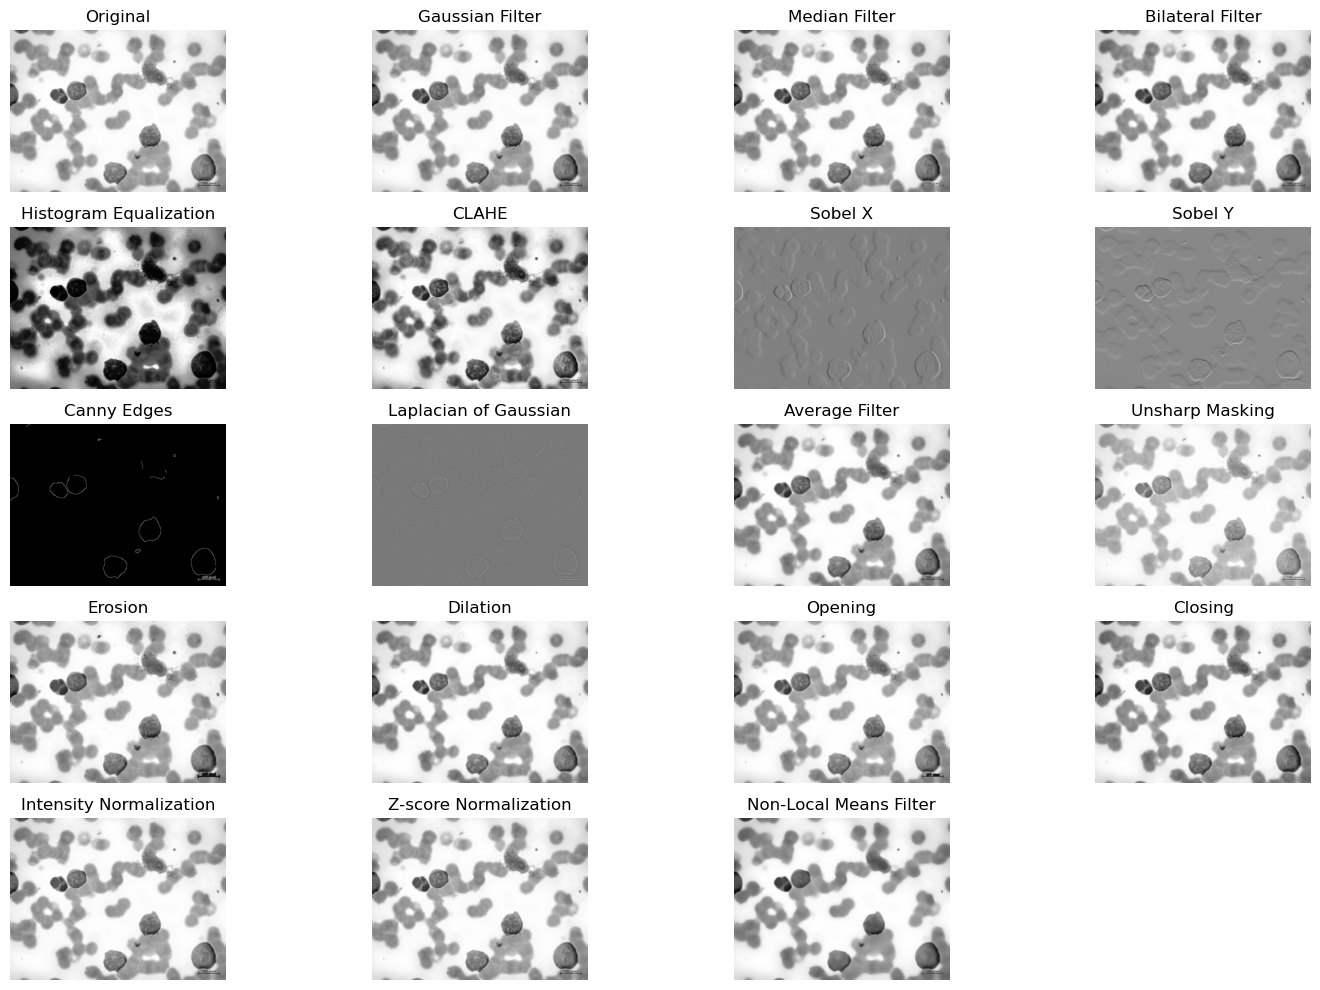

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image_path = r'C:\Users\Dell\OneDrive\Desktop\Blood cancer 4\Blood cell Cancer [ALL]_splits\test\[Malignant] early Pre-B\Sap_148 (3).jpg'
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function to display images
def display_images(images, titles, cols=3):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(len(images) // cols + 1, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 1. Noise Reduction
gaussian_filtered = cv2.GaussianBlur(image_gray, (5, 5), 0)
median_filtered = cv2.medianBlur(image_gray, 5)
bilateral_filtered = cv2.bilateralFilter(image_gray, 9, 75, 75)

# 2. Contrast Enhancement
hist_eq = cv2.equalizeHist(image_gray)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_filtered = clahe.apply(image_gray)

# 3. Edge Detection
sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=5)
canny_edges = cv2.Canny(image_gray, 100, 200)
log = cv2.GaussianBlur(image_gray, (5, 5), 0)
log_edges = cv2.Laplacian(log, cv2.CV_64F)

# 4. Image Smoothing and Sharpening
average_filtered = cv2.blur(image_gray, (5, 5))
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Unsharp Mask
unsharp_masked = cv2.filter2D(image_gray, -1, kernel)

# 5. Morphological Operations
kernel_morph = np.ones((5, 5), np.uint8)
eroded = cv2.erode(image_gray, kernel_morph, iterations=1)
dilated = cv2.dilate(image_gray, kernel_morph, iterations=1)
opened = cv2.morphologyEx(image_gray, cv2.MORPH_OPEN, kernel_morph)
closed = cv2.morphologyEx(image_gray, cv2.MORPH_CLOSE, kernel_morph)

# 6. Normalization
intensity_normalized = cv2.normalize(image_gray, None, 0, 255, cv2.NORM_MINMAX)
zscore_normalized = (image_gray - np.mean(image_gray)) / np.std(image_gray)

# 7. Other Filters
wiener_filtered = cv2.fastNlMeansDenoising(image_gray, None, 30, 7, 21)  # Non-Local Means Filter

# Prepare titles and images for display
titles = [
    # Noise Reduction
    'Original', 'Gaussian Filter', 'Median Filter', 'Bilateral Filter',
    # Contrast Enhancement
    'Histogram Equalization', 'CLAHE', 
    # Edge Detection
    'Sobel X', 'Sobel Y', 'Canny Edges', 'Laplacian of Gaussian',
    # Image Smoothing and Sharpening
    'Average Filter', 'Unsharp Masking', 
    # Morphological Operations
    'Erosion', 'Dilation', 'Opening', 'Closing',
    # Normalization
    'Intensity Normalization', 'Z-score Normalization',
    # Other Filters
    'Non-Local Means Filter'
]

images = [
    image_gray, gaussian_filtered, median_filtered, bilateral_filtered,
    hist_eq, clahe_filtered, 
    sobel_x, sobel_y, canny_edges, log_edges,
    average_filtered, unsharp_masked, 
    eroded, dilated, opened, closed,
    intensity_normalized, zscore_normalized,
    wiener_filtered
]

# Display the images
display_images(images, titles, cols=4)

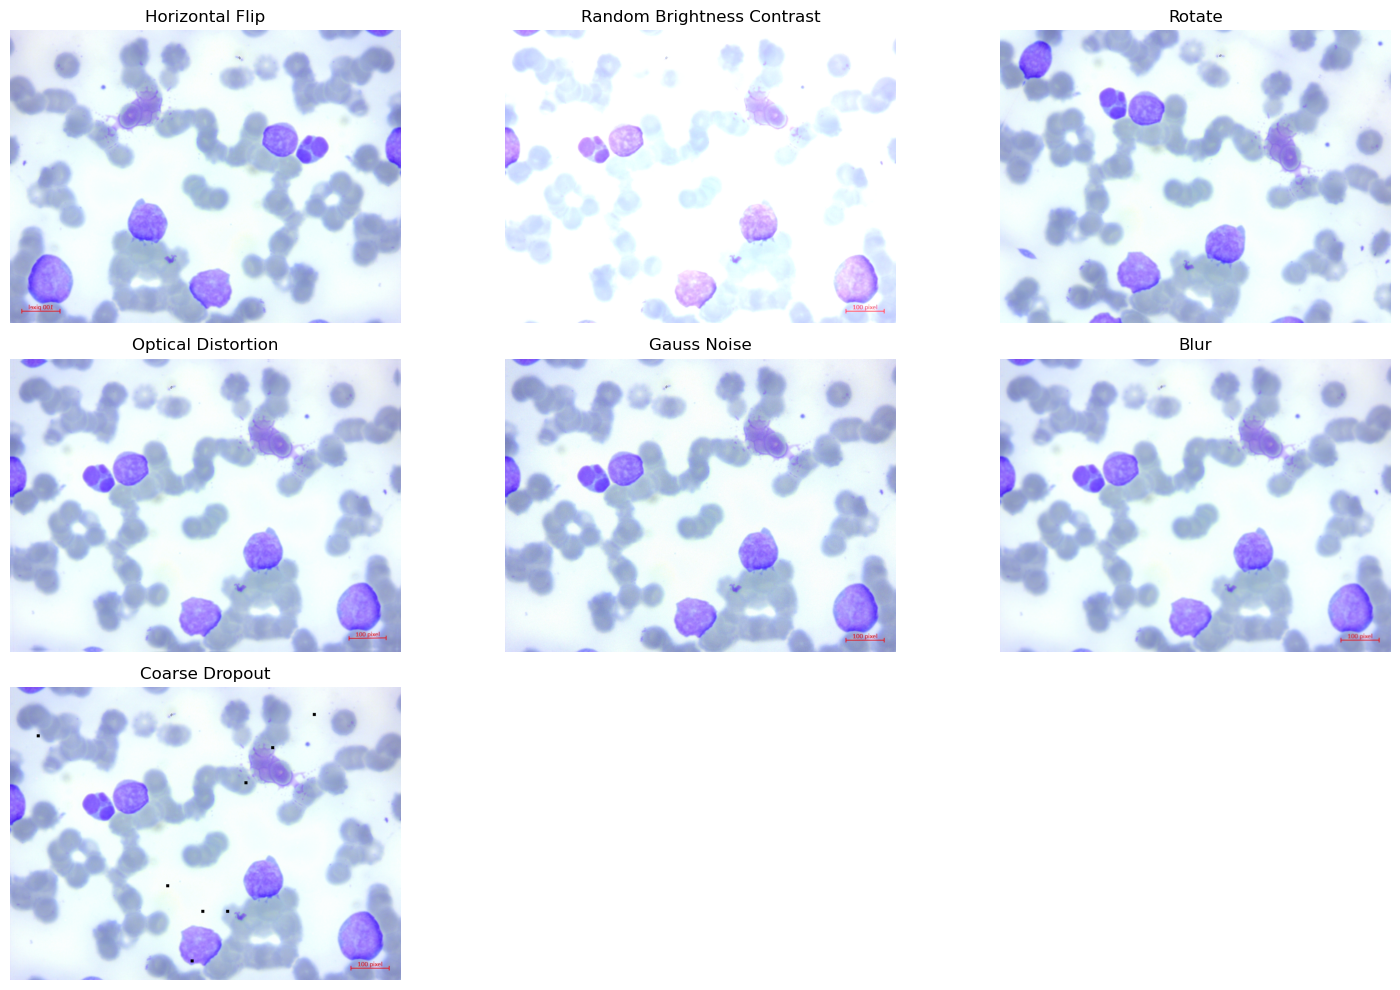

In [22]:
import cv2
import numpy as np
import albumentations as A
from matplotlib import pyplot as plt

# Load an image
image = cv2.imread(r'C:\Users\Dell\OneDrive\Desktop\Blood cancer 4\Blood cell Cancer [ALL]_splits\test\[Malignant] early Pre-B\Sap_148 (3).jpg')

# Define individual augmentations
augmentations = [
    ('Horizontal Flip', A.HorizontalFlip(p=1)),
    ('Random Brightness Contrast', A.RandomBrightnessContrast(p=1.0)),
    ('Rotate', A.Rotate(limit=40, p=1.0)),
    ('Optical Distortion', A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0)),
    ('Gauss Noise', A.GaussNoise(var_limit=(10.0, 50.0), p=1.0)),
    ('Blur', A.Blur(blur_limit=3, p=1.0)),
    ('Coarse Dropout', A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0))
]

# Apply and display each augmentation separately
plt.figure(figsize=(15, 10))
for i, (name, aug) in enumerate(augmentations):
    augmented_image = aug(image=image)["image"]
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [27]:
!pip install torchsummary
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

# Check device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ConvNeXt Tiny model
pretrained_convnext = torchvision.models.convnext_tiny(pretrained=True).to(device)

# Freeze base model layers
for param in pretrained_convnext.parameters():
    param.requires_grad = False

# Modify the classifier head to match the number of classes (4 in your case)
num_classes = 4
pretrained_convnext.classifier[2] = nn.Linear(in_features=768, out_features=num_classes).to(device)

# Print the model summary
summary(pretrained_convnext, input_size=(3, 224, 224))  # Assuming input size is (3, 224, 224)


C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ConvNeXt Tiny model
pretrained_convnext = torchvision.models.convnext_tiny(pretrained=True).to(device)

# Freeze base model layers
for param in pretrained_convnext.parameters():
    param.requires_grad = False

# Modify the classifier head to match the number of classes (4 in your case)
pretrained_convnext.classifier[2] = nn.Linear(in_features=768, out_features=len(classes)).to(device)


In [7]:
optimizer = torch.optim.Adam(pretrained_convnext.classifier[2].parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


In [8]:
epochs = 25
train_loss, val_loss, train_acc, val_acc = [], [], [], []

for epoch in range(epochs):
    pretrained_convnext.train()
    epoch_train_loss, correct_train = 0, 0
    
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_convnext(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == labels).sum().item()

    train_loss.append(epoch_train_loss / len(train_loader))
    train_acc.append(correct_train / len(train_dataset))

    # Validation step
    pretrained_convnext.eval()
    epoch_val_loss, correct_val = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = pretrained_convnext(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()

    val_loss.append(epoch_val_loss / len(val_loader))
    val_acc.append(correct_val / len(val_dataset))

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")


Epoch 1/25 - Train Loss: 1.2148, Train Acc: 0.5472, Val Loss: 1.0328, Val Acc: 0.7531
Epoch 2/25 - Train Loss: 0.9512, Train Acc: 0.7659, Val Loss: 0.8167, Val Acc: 0.8107
Epoch 3/25 - Train Loss: 0.7779, Train Acc: 0.8157, Val Loss: 0.6772, Val Acc: 0.8498
Epoch 4/25 - Train Loss: 0.6589, Train Acc: 0.8545, Val Loss: 0.5776, Val Acc: 0.8663
Epoch 5/25 - Train Loss: 0.5720, Train Acc: 0.8748, Val Loss: 0.5032, Val Acc: 0.9095
Epoch 6/25 - Train Loss: 0.5051, Train Acc: 0.8915, Val Loss: 0.4437, Val Acc: 0.9095
Epoch 7/25 - Train Loss: 0.4532, Train Acc: 0.9109, Val Loss: 0.3996, Val Acc: 0.9177
Epoch 8/25 - Train Loss: 0.4158, Train Acc: 0.9184, Val Loss: 0.3609, Val Acc: 0.9280
Epoch 9/25 - Train Loss: 0.3756, Train Acc: 0.9352, Val Loss: 0.3314, Val Acc: 0.9383
Epoch 10/25 - Train Loss: 0.3430, Train Acc: 0.9409, Val Loss: 0.3046, Val Acc: 0.9486
Epoch 11/25 - Train Loss: 0.3242, Train Acc: 0.9475, Val Loss: 0.2843, Val Acc: 0.9568
Epoch 12/25 - Train Loss: 0.3021, Train Acc: 0.9541,

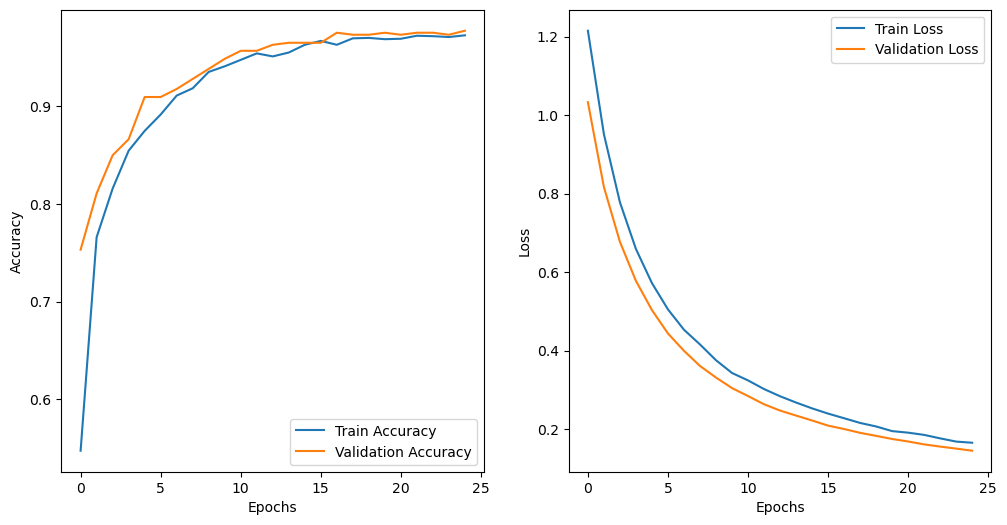

In [9]:
# Visualize training/validation accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [10]:
pretrained_convnext.eval()
correct_test = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = pretrained_convnext(inputs)
        correct_test += (outputs.argmax(1) == labels).sum().item()

test_accuracy = correct_test / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9836


In [11]:
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = pretrained_convnext(inputs)
        predictions = outputs.argmax(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Accuracy, precision, recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


                         precision    recall  f1-score   support

                 Benign       0.99      0.92      0.95        77
      [Malignant] Pre-B       0.99      0.99      0.99       144
      [Malignant] Pro-B       0.99      1.00      1.00       120
[Malignant] early Pre-B       0.97      1.00      0.98       147

               accuracy                           0.98       488
              macro avg       0.98      0.98      0.98       488
           weighted avg       0.98      0.98      0.98       488

Accuracy: 0.9836, Precision: 0.9838, Recall: 0.9836, F1-Score: 0.9834


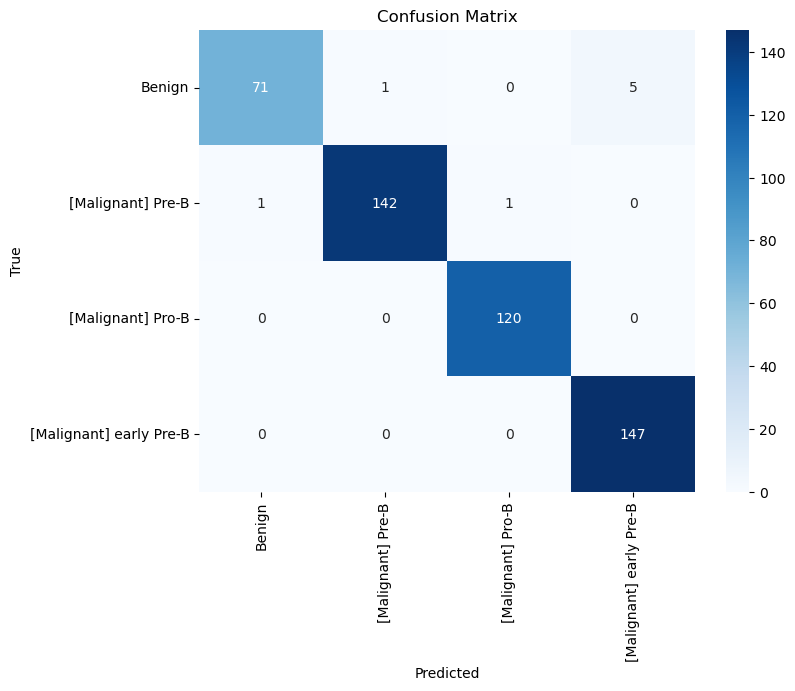

In [12]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
from PIL import Image

def predict_image(image_path, model, class_names, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
    pred = output.argmax(1).item()
    return class_names[pred]

# Predicting a custom image
image_path = r'C:\Users\Dell\OneDrive\Desktop\n.jpg'
prediction = predict_image(image_path, pretrained_convnext, classes, val_transform, device)
print(f"Predicted Class: {prediction}")


Predicted Class: [Malignant] Pre-B
